In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.manage.configuration import get_profile

from aiida.common.datastructures import CalcInfo, CodeInfo
from aiida.common.folders import Folder

from aiida.engine import CalcJob, WorkChain
from aiida.engine import calcfunction, workfunction, submit, run, run_get_node

from aiida.plugins import DataFactory, WorkflowFactory

from aiida.parsers.parser import Parser
from aiida.orm import Code
from aiida.orm import load_code, load_node
from aiida.orm import Str, Dict, Float, Int
from aiida.orm import QueryBuilder

import aiida

from ase.io.espresso import write_espresso_in
from ase.io.lammpsdata import read_lammps_data
from ase.build import make_supercell
from ase import Atom, Atoms
import ase

from itertools import combinations_with_replacement
import numpy as np
import os
import subprocess
import shutil
import re
from time import sleep
import spglib
import json

from os.path import expanduser

from tools import NodeBank
from tools import wait_for_node_finished
from aiida_alamode.io import load_atoms
from tools.putstructure import PutStructure


In [3]:
# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')


In [4]:
g_graph = True

with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path


{'CWD': 'run35'}


'/home/max/Documents/aiida-alamode_public/example/run35'

In [5]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os

home = expanduser("~")
work_directory = os.path.join(home, 'aiida')
computer_label = 'localhost'  # localhost, mygarden1. mygarden2
computer = get_or_create_local_computer(work_directory, computer_label)

if True:
    code = get_or_create_code('alamode.alm_suggest',
                              computer,
                              '/home/max/Documents/alamode/bin/alm')
    code_alm_sugget = code
else:
    code_alm_sugget = load_code(label=f'alm_suggest_{computer_label}')
# else:
#    code_alm_sugget = WorkflowFactory('alamode.alm_ALM_suggest')

code_alm_sugget


<Code: Remote code 'alamode.alm_suggest' on localhost, pk: 2326, uuid: 32253ce4-318f-4c70-b09d-977a5307c78b>

In [6]:
# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)


In [7]:
# 計算するroot directoryの定義
key = 'root_wd'
g_root_wd = nodebank.load(key)


In [8]:
# harmonic partの計算を行う。
g_prefix = Str("harmonic")
g_norder = Int(1)

g_prefix = nodebank.dump("prefix", g_prefix)
g_norder = nodebank.dump(f"{g_prefix.value}_norder", g_norder)
g_factor = nodebank.load('factor')
g_norder, g_prefix,  g_factor


(<Int: uuid: 5f617e93-0c19-4c8c-859b-b490418f9a8b (pk: 3588) value: 1>,
 <Str: uuid: 43812d12-3c45-4981-8877-26f40299b550 (pk: 3587) value: harmonic>,
 <ArrayData: uuid: c76688bd-96e5-4f06-9f3d-e39eb089dcbb (pk: 3559)>)

In [9]:
g_standardizedstructure = nodebank.load("standardizedstructure")
g_factor = nodebank.load('factor')
g_standardizedstructure.get_ase(), g_factor.get_array('factor')


(Atoms(symbols='Si8', pbc=False, cell=[5.4, 5.4, 5.4], masses=...),
 array([[2, 0, 0],
        [0, 2, 0],
        [0, 0, 2]]))

In [10]:
# ファイルを置くsubdirectory名の作成
# ディレクトリ名 cwd=formula_supercell_harmonic
# ディレクトリがなければ作成する。
g_almprefix = "_".join([g_standardizedstructure.get_formula(), "x".join(
    map(str, g_factor.get_array("factor").reshape(-1))), g_prefix.value])
g_almprefix = Str(g_almprefix)
print(g_almprefix)

# cwdの設定
g_cwd = Str(os.path.join(g_root_wd.value, g_almprefix.value))
g_cwd = nodebank.load_or_dump("cwd", g_cwd)
# 無ければ作成。
os.makedirs(g_cwd.value, exist_ok=True)


uuid: 21bc9451-65d5-4ae3-b2f0-2b02e48132f7 (unstored) value: Si8_2x0x0x0x2x0x0x0x2_harmonic
debug, node uuid: d550571e-5ab9-4511-9057-b77e5fa01f1d (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic
debug, load None
debug, force dump


In [11]:

g_primstructure = nodebank.load("primstructure")
g_superstructure = nodebank.load("superstructure")


## alm suggest

```
Description:

	alm mode="suggest"
	
	default input filename: alm_suggest.in
	default output filename: alm_suggest.out

Inputs:
           code:  required  Code             The `Code` to use for this job.
         norder:  required  Int              1 (harmonic) or 2 (cubic)
      structure:  required  StructureData    structure of cyrstal.
         cutoff:  optional  Dict             distance cutoff
            cwd:  optional  Str              directory where results are saved.
       metadata:  optional                   
           mode:  optional  Str              mode of alm='suggest'
          param:  optional  Dict             optional parameters
         prefix:  optional  Str              string added to the filename.
Outputs:
        pattern:  required  List             pattern of displacement
  remote_folder:  required  RemoteData       Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict             
      retrieved:  required  FolderData       Files that are retrieved by the daemon will be stored in this node. By defa ...
   remote_stash:  optional  RemoteStashData  Contents of the `stash.source_list` option are stored in this remote folder ...

```

In [12]:
codetype = "calculation"
try:
    if issubclass(code_alm_sugget, WorkChain):
        codetype = "workchain"
except TypeError:
    codetype = "calculation"

if codetype == "workchain":
    g_cutoff_radii = List(list=[[-1]])
    g_nbody = List(list=[2])
    inputs = {'structure': g_superstructure,
              'norder': g_norder,
              'cwd': Str(os.path.join(g_cwd.value, f"{g_prefix.value}_alm_suggest")),
              'cutoff_radii': g_cutoff_radii,
              'nbody': g_nbody
              }
    g_alm_suggest_future = submit(code_alm_sugget, **inputs)
    print(g_alm_suggest_future)
    wait_for_node_finished(g_alm_suggest_future)
else:
    print("code")
    # inputs
    code = code_alm_sugget
    builder = code.get_builder()
    builder.structure = g_superstructure  # equilibrium structure
    builder.norder = g_norder
    builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_alm_suggest"))
    # calcjobの場合はmetadataを加える。
    builder.metadata = {
        'options': {
            'resources': {'tot_num_mpiprocs': 1, 'num_machines': 1}
        }}


    g_alm_suggest_future = nodebank.load_code_or_wait_for_node(f"{g_prefix.value}_alm_suggest", builder)


code
None
uuid: e037e2dd-561b-4973-ac48-94fe51455a2c (pk: 3595) (aiida.calculations:alamode.alm_suggest)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
0:00:12.302452


In [13]:
Str(os.path.join(g_cwd.value, f"{g_prefix.value}_alm_suggest"))


<Str: uuid: 1ba2fc42-4a2f-43eb-a16d-6fa31788719a (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_alm_suggest>

In [14]:
# outputs
g_alm_suggest_future.outputs.results.get_dict()

{'num_disp': {'HARMONIC': '1'},
 'num_free_fcs,': {'HARMONIC': 26},
 'disp_pattern_filenames': {'HARMONIC': 'disp.pattern_HARMONIC'}}

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3595.dot.pdf


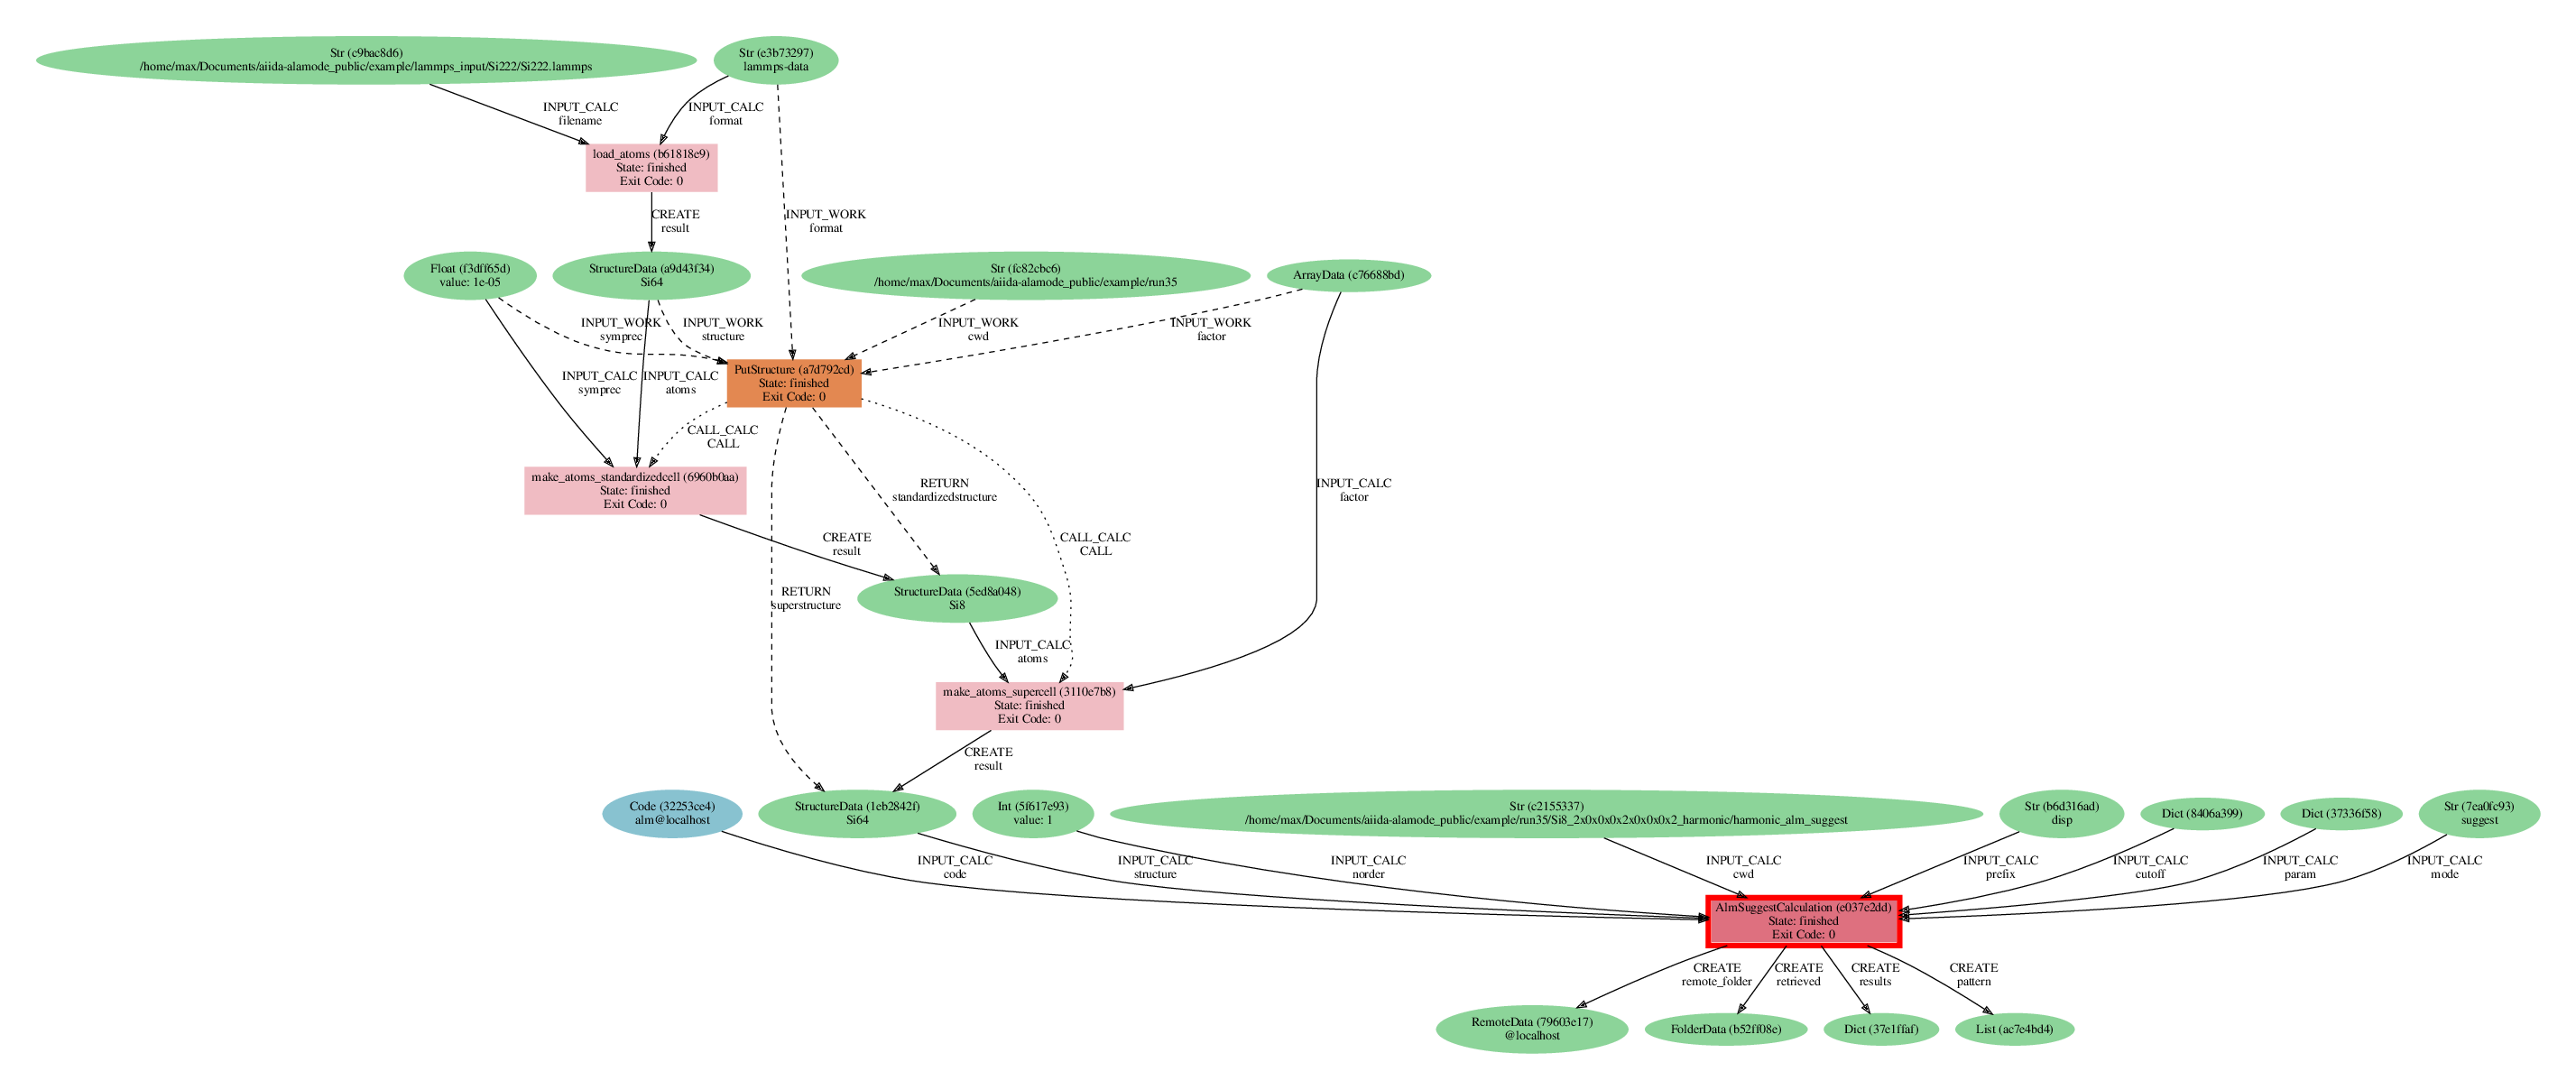

In [15]:
if g_graph:
    pk = g_alm_suggest_future.pk
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)

In [16]:
# pattern fileリストはg_alm_suggest_future.outputs.pattern_folderに入る。
# 次の実行ファイルで用いるために保存する。
nodebank.dump(f"{g_prefix.value}_pattern",
              g_alm_suggest_future.outputs.pattern)


<List: uuid: ac7e4bd4-3248-4fad-b6f7-a9796dfb6ec7 (pk: 3599) value: [[[[0, [1.0, 0.0, 0.0], 'Cartesian']]]]>